### Adverserial Attacks

We are going to perform 2 attacks on a deep neural network classifier. The attacks FGSM attacks and PGD_attacks

In [1]:
# Importing relevant libraries
import tensorflow as tf
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
pathh = 'MNISTClassifier'

for parent, dirs, files in os.walk(pathh, topdown=False):
  for file in files:
    file_path = os.path.join(parent, file)
    os.remove(file_path)
  for dir in dirs:
    dir_path = os.path.join(parent, dir)
    os.rmdir(dir_path)

  os.rmdir('/content/MNISTClassifier')

In [3]:
# loading the daa
(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28, 28)).astype("float32") / 255
images = np.expand_dims(images, axis=3)
test_images = test_images.reshape((10000, 28, 28)).astype("float32") / 255
test_images = np.expand_dims(test_images, axis=3)
x_train, x_test = images[10000:], images[:10000]
y_train, y_test = labels[10000:], labels[:10000]

11490434/11490434 [==============================] - 0s 0us/step


2


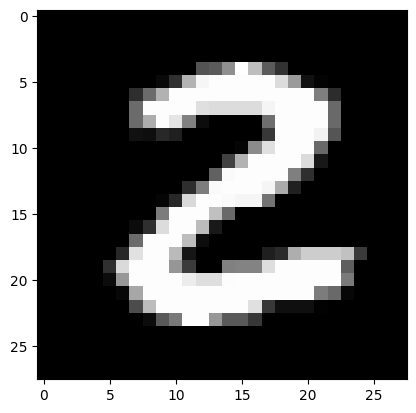

In [4]:
# inspect the data
x_test[5].shape
digit = x_test[25]
fig = plt.figure
plt.imshow(digit, cmap='gray')
print(y_test[16])

In [5]:
 class MNISTClassifier(tf.keras.Model):
    def __init__(self):
        super(MNISTClassifier, self).__init__()

        # Define the layers
        #for feature extration
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1))
        self.max_pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.max_pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.dropout1 = tf.keras.layers.Dropout(0.25)
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.dense2 = tf.keras.layers.Dense(10)
        self.layers_list = [self.conv1, self.max_pool1, self.conv2, self.max_pool2,
                           self.flatten, self.dropout1, self.dense1, self.dropout2, self.dense2]
    @tf.function
    def call(self, *args, **kwargs):
        # Define the forward pass
        # output is the model logits
        activation_list = []
        out = args[0]
        for layer in self.layers_list:
           out = layer(out)
           activation_list.append(out)

        if kwargs['training']:
          #notice that training is a kw argument checked when fit is called
          #so when model is training, all I need is the output logits to call the loss function upon
          return out
        else:
          prob = tf.nn.softmax(out)
          return out, prob

In [6]:
class SaveFinalTrainingLogitsProp(keras.callbacks.Callback):
  def on_train_end(self, logs):
    self.out = model.predict(x_train)
    self.prob = tf.nn.softmax(self.out)
    print(self.out.shape, self.prob.shape)

In [7]:
## Train a model and save
model = MNISTClassifier()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

model.save('MNISTClassifier')

Epoch 1/10
1563/1563 [==============================] - 67s 42ms/step - loss: 0.2375 - accuracy: 0.9274 - val_loss: 0.0616 - val_accuracy: 0.9815
Epoch 2/10
1563/1563 [==============================] - 62s 40ms/step - loss: 0.0899 - accuracy: 0.9730 - val_loss: 0.0490 - val_accuracy: 0.9862
Epoch 3/10
1563/1563 [==============================] - 62s 39ms/step - loss: 0.0663 - accuracy: 0.9796 - val_loss: 0.0424 - val_accuracy: 0.9868
Epoch 4/10
1563/1563 [==============================] - 49s 32ms/step - loss: 0.0560 - accuracy: 0.9830 - val_loss: 0.0444 - val_accuracy: 0.9883
Epoch 5/10
1563/1563 [==============================] - 54s 34ms/step - loss: 0.0475 - accuracy: 0.9847 - val_loss: 0.0389 - val_accuracy: 0.9896
Epoch 6/10
1563/1563 [==============================] - 50s 32ms/step - loss: 0.0439 - accuracy: 0.9863 - val_loss: 0.0347 - val_accuracy: 0.9906
Epoch 7/10
1563/1563 [==============================] - 59s 38ms/step - loss: 0.0384 - accuracy: 0.9878 - val_loss: 0.0362 -

In [13]:
def run_attacks(img_arr, class_arr, model, att_func):
  result = []
  # result contains a tupple of AE and Pertubation

  for img, cls in zip(img_arr, class_arr):
    x_test_adv, perturbation = att_func(model, img, cls, 0.1)
    result.append((x_test_adv, perturbation))

  return result

def pred_data(reshaped_sample_twos):
  pred = []
  prediction = []
  for sample in reshaped_sample_twos:
    sample_prediction = model.predict(sample)
    pred.append(np.argmax(sample_prediction))
    prediction.append(sample_prediction)
  # print(np.argmax(prediction))
  print(np.argmax(prediction[0][1]))
  return prediction


def load_data(twos_tuple):
  reshaped_sample_twos = []
  for tup in twos_tuple:
    a_two = x_test[tup[0]]
    a_two = np.reshape(a_two, (-1, 28, 28, 1))
    reshaped_sample_twos.append(a_two)
  reshaped_sample_twos = np.array(reshaped_sample_twos)
  return reshaped_sample_twos

def get_sample_data(n):
  few_samples = []
  count = 0
  for index, label in enumerate(y_test):
    if count > 9:
      break
    if label == n:
      few_samples.append((index, label))
      count += 1
  return few_samples

In [9]:
model = tf.keras.models.load_model('MNISTClassifier')

In [10]:
def fgsm(model, x, y, eps):
  # tensor of same shape as x to hold perturbation
  #x coming in is already perturbed version of x
  # delta = tf.zeros_like(x)
  y = tf.one_hot(y, 10)
  y = np.reshape(y, (1,10))
  y_pred = None
  actual= None
  predicted= None

  num_iteration = 1
  x = tf.cast(x, tf.float32)
  while (num_iteration < 100):

    with tf.GradientTape() as tape:
        tape.watch(x)
        y_pred = model(x)
        y_pred = y_pred[1]
        # print("y_pred", y_pred)
        # print("y", y)
        loss = tf.keras.losses.categorical_crossentropy(y, y_pred, from_logits=True)
    gradient = tape.gradient(loss, x)
    gradient /= tf.math.reduce_std(gradient) + 1e-8
    signed_grad = tf.sign(gradient)
    perturbation = eps*signed_grad
    adv_x = x + perturbation
    adv_x = tf.clip_by_value(adv_x, 0, 1) # make sure the perturbed image is still in [0, 1] range
    x = adv_x
    if num_iteration%10 == 0:
      print(f"Num_iterations: {num_iteration} \n Y_Pred: {np.argmax(y_pred)} \n Y: {np.argmax(y)}")
    if np.argmax(y_pred) != np.argmax(y):
      actual = np.argmax(y)
      predicted = np.argmax(y_pred)
      break
    num_iteration += 1

  return adv_x, perturbation, actual, predicted

In [ ]:
final_results = []
for a in range(10):
  original_images = []
  adversarial_images = []
  perturbations = []
  sample_tuple = get_sample_data(a)
  reshaped_samples = load_data(sample_tuple)
  for x in reshaped_samples:
    x_test_adv, perturbation, actuals, y_predicted = fgsm(model, x, a, 0.01)
    print(actuals, y_predicted)
    if actuals != y_predicted:
      original_images.append(x)
      # x_test_adv, perturbation = fgsm(model, x, a, 0.01)
      adversarial_images.append(x_test_adv)
      perturbations.append(perturbation)

      final_results.append([x, x_test_adv, perturbation, actuals, y_predicted])


In [45]:
image_number = 89

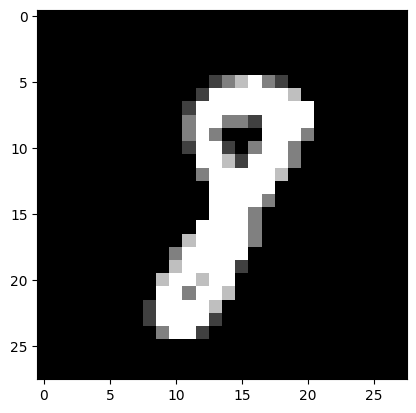

In [46]:
squeeze_original = np.expand_dims(np.squeeze(final_results[image_number][0]), axis=2)
fig = plt.figure
plt.imshow(squeeze_original, cmap='gray')
# print(y_test[16])

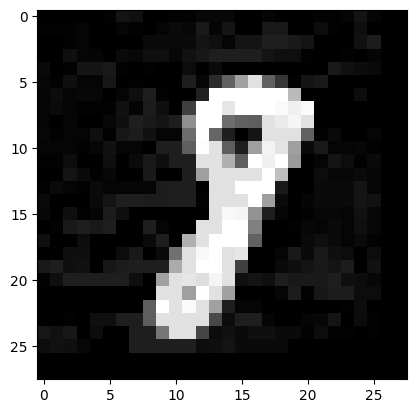

In [47]:
squeze_adversarial = np.expand_dims(np.squeeze(final_results[image_number][1]), axis=2)
fig = plt.figure
plt.imshow(squeze_adversarial, cmap='gray')

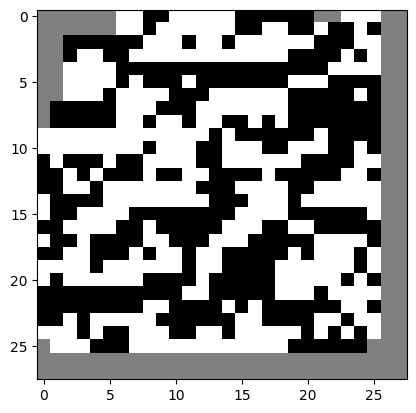

In [48]:
squeze_perturbation = np.expand_dims(np.squeeze(final_results[image_number][2]), axis=2)
fig = plt.figure
plt.imshow(squeze_perturbation, cmap='gray')

In [68]:
def plot_images(image_number):
  original = final_results[image_number][0]
  adv_pred = model.predict(final_results[image_number][2])
  org_pred = model.predict(final_results[image_number][1])

  org_pred = np.argmax(org_pred[1])
  adv_pred = np.argmax(adv_pred[1])
  # print(np.argmax(org_pred[1]))

  org_image = np.expand_dims(np.squeeze(final_results[image_number][0]), axis=2)
  adv_image = np.expand_dims(np.squeeze(final_results[image_number][1]), axis=2)
  perturbation = np.expand_dims(np.squeeze(final_results[image_number][2]), axis=2)
  print("orig img", org_image.shape)
  print("adv img", adv_image.shape)
  fig = plt.figure(figsize=(10, 10))

  rows = 1
  columns = 3

  fig.add_subplot(rows, columns, 1)
  plt.imshow(org_image, cmap='gray')
  plt.axis('off')
  plt.title(f'Original Image \n prediction: {final_results[image_number][3]}')

  fig.add_subplot(rows, columns, 2)
  plt.imshow(perturbation, cmap='gray')
  plt.axis('off')
  plt.title(f'Pertubation: {final_results[image_number][4]}')

  fig.add_subplot(rows, columns, 3)
  plt.imshow(adv_image, cmap='gray')
  plt.axis('off')
  plt.title(f'Adversarial Image \n Prediction: {final_results[image_number][4]}')


In [49]:
original = final_results[image_number][0]
adv_pred = model.predict(final_results[image_number][2])
org_pred = model.predict(final_results[image_number][1])

org_pred = np.argmax(org_pred[1])
adv_pred = np.argmax(adv_pred[1])
# print(np.argmax(org_pred[1]))

org_image = np.expand_dims(np.squeeze(final_results[image_number][0]), axis=2)
adv_image = np.expand_dims(np.squeeze(final_results[image_number][1]), axis=2)
perturbation = np.expand_dims(np.squeeze(final_results[image_number][2]), axis=2)
print("orig img", org_image.shape)
print("adv img", adv_image.shape)

1/1 [==============================] - 0s 35ms/step


Text(0.5, 1.0, 'Adversarial Image \n Prediction: 9')

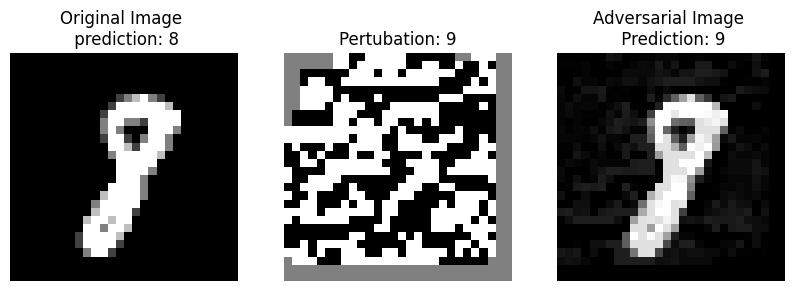

In [52]:
fig = plt.figure(figsize=(10, 10))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(org_image, cmap='gray')
plt.axis('off')
plt.title(f'Original Image \n prediction: {final_results[image_number][3]}')

fig.add_subplot(rows, columns, 2)
plt.imshow(perturbation, cmap='gray')
plt.axis('off')
plt.title(f'Pertubation: {final_results[image_number][4]}')

fig.add_subplot(rows, columns, 3)
plt.imshow(adv_image, cmap='gray')
plt.axis('off')
plt.title(f'Adversarial Image \n Prediction: {final_results[image_number][4]}')

Attack Evaluation

In [53]:
def euclidean_distance(ori, adv):
  orig = np.array(ori).flatten()
  adve = np.array(adv).flatten()
  dist = np.linalg.norm(orig - adve)
  return dist

In [54]:
fgsm_ = []
for b in range(len(final_results)):
  fgsm_.append(euclidean_distance(final_results [b][0], final_results [b][1]))

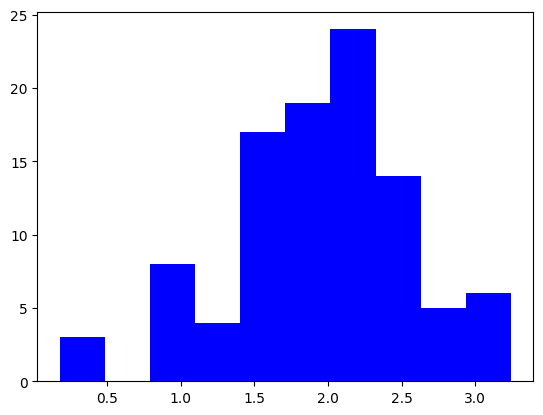

In [57]:
plt.figure()
plt.hist(fgsm_, color='blue')
plt.show()

1/1 [==============================] - 0s 21ms/step
orig img (28, 28, 1)
adv img (28, 28, 1)


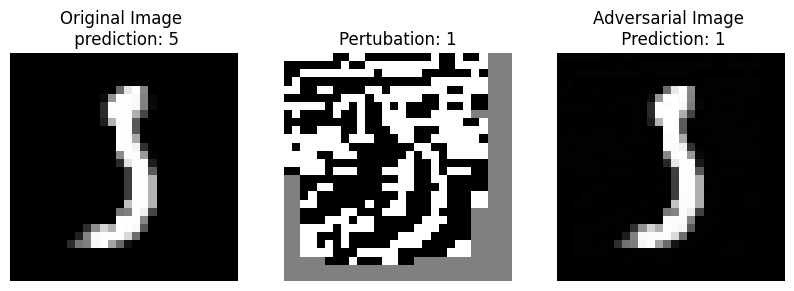

In [69]:
minimum = fgsm_.index(min(fgsm_))
plot_images(minimum)

1/1 [==============================] - 0s 43ms/step
orig img (28, 28, 1)
adv img (28, 28, 1)


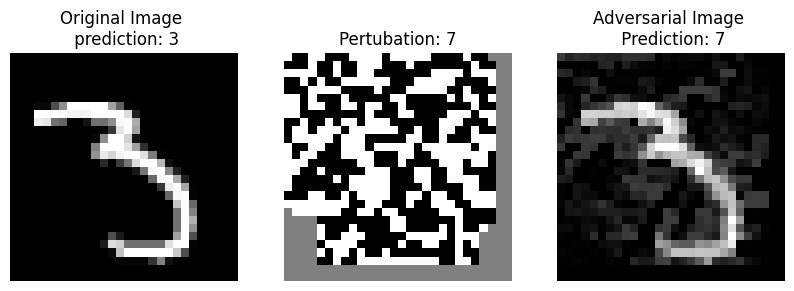

In [70]:
maximum = fgsm_.index(max(fgsm_))
plot_images(maximum)

#### CW Attacks

In [72]:
def cw_attack(model, image, target_class, max_iterations=12, confidence=0.0, learning_rate=0.01):
  #cw_attack loss function
  def cw_loss(logits, target_class, confidence):
    target_one_hot = tf.one_hot(target_class, logits.shape[1])
    correct_logits = tf.reduce_sum(target_one_hot * logits, axis=1)
    other_logits = tf.reduce_max((1-target_one_hot) * logits - target_one_hot * 10000, axis=1)
    loss = tf.maximum(0.0, other_logits - correct_logits + confidence)
    return tf.reduce_mean(loss)

  image_shape = image.shape
  image = tf.convert_to_tensor(image)
  image = tf.expand_dims(image, axis=0)

  target_class = tf.convert_to_tensor(target_class)

  image_var = tf.Variable(image, dtype=tf.float32)

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  for iteration in range(max_iterations):
    with tf.GradientTape() as tape:
      logits = model(image_var)
      loss = cw_loss(logits, target_class, confidence)

    gradients = tape.gradient(loss, image_var)
    optimizer.apply_gradients([(gradients, image_var)])

    image_var.assign(tf.clip_by_value(image_var, 0.0, 0.1))

    if iteration % 100 == 0:
      print(f"iteration: {iteration} \t loss: {loss.numpy()}")

  adversarial_image = image_var.numpy().reshape(image_shape)

  return adversarial_image

In [74]:
(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape(60000, 28, 28).astype("float32")/255
images = np.expand_dims(images, axis=3)
test_images = test_images.reshape(10000, 28, 28).astype("float32")/255
test_images = np.expand_dims(test_images, axis=3)
x_train, x_test = images[10000:], images[:10000]
y_train, y_test = labels[10000:], labels[:10000]


In [76]:
#create validation data from train dataset
print(len(x_train))
x_train, x_val = x_train[10000:], x_train[:10000]
y_train, y_val = y_train[10000:], y_train[:10000]
print(len(x_train))

50000
40000


In [75]:
class MNISTClassifier(tf.keras.Model):
  def __init__(self):
    super(MNISTClassifier, self).__init__()

    #define the layers for feature extraction
    self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1))
    self.max_pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
    self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
    self.max_pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
    self.flatten = tf.keras.layers.Flatten()
    self.dropout1 = tf.keras.layers.Dropout(0.25)
    self.dense1 = tf.keras.layers.Dense(128, activation='relu')
    self.dropout2 = tf.keras.layers.Dropout(0.5)
    self.dense2 = tf.keras.layers.Dense(10)
    self.layers_list = [self.conv1, self.max_pool1, self.conv2, self.max_pool2,
                        self.flatten, self.dropout1, self.dense1, self.dropout2, self.dense2]

  def call(self, *args, **kwargs):
    #define forward pass
    activation_list = []
    out = args[0]
    for layer in self.layers_list:
      out = layer(out)
      activation_list.append(out)

    return out

In [78]:
model = MNISTClassifier()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))
model.save('MNISTClassifier')
model.summary()

Epoch 1/10
1250/1250 [==============================] - 43s 33ms/step - loss: 0.2750 - accuracy: 0.9129 - val_loss: 0.0685 - val_accuracy: 0.9799
Epoch 2/10
1250/1250 [==============================] - 46s 37ms/step - loss: 0.1047 - accuracy: 0.9676 - val_loss: 0.0466 - val_accuracy: 0.9861
Epoch 3/10
1250/1250 [==============================] - 39s 31ms/step - loss: 0.0774 - accuracy: 0.9764 - val_loss: 0.0382 - val_accuracy: 0.9893
Epoch 4/10
1250/1250 [==============================] - 39s 31ms/step - loss: 0.0626 - accuracy: 0.9809 - val_loss: 0.0334 - val_accuracy: 0.9900
Epoch 5/10
1250/1250 [==============================] - 42s 34ms/step - loss: 0.0547 - accuracy: 0.9830 - val_loss: 0.0404 - val_accuracy: 0.9879
Epoch 6/10
1250/1250 [==============================] - 42s 34ms/step - loss: 0.0481 - accuracy: 0.9847 - val_loss: 0.0291 - val_accuracy: 0.9917
Epoch 7/10
1250/1250 [==============================] - 42s 34ms/step - loss: 0.0446 - accuracy: 0.9858 - val_loss: 0.0305 -

In [79]:
model = tf.keras.models.load_model('MNISTClassifier')

In [82]:
final_results = []
for c in range(10):
  for d in range(10):
    sample_tuple = get_sample_data(c)
    reshaped_sample = load_data(sample_tuple)
    ori_image = tf.squeeze(reshaped_sample[d], axis=0)
    adv_image = cw_attack(model, ori_image, d)
    predicted = np.argmax(model.predict(np.expand_dims(adv_image, axis=0)))
    if c != predicted:
      final_results.append([ori_image, adv_image, c,  predicted])

    print("Actual: " + str(c) + "predicted: " + str(predicted))


iteration: 0 	 loss: 0.0
1/1 [==============================] - 0s 32ms/step
Actual: 0predicted: 0
iteration: 0 	 loss: 22.417911529541016
1/1 [==============================] - 0s 34ms/step
Actual: 0predicted: 1
iteration: 0 	 loss: 15.576720237731934
1/1 [==============================] - 0s 33ms/step
Actual: 0predicted: 3
iteration: 0 	 loss: 21.62158966064453
1/1 [==============================] - 0s 33ms/step
Actual: 0predicted: 3
iteration: 0 	 loss: 24.111980438232422
1/1 [==============================] - 0s 35ms/step
Actual: 0predicted: 1
iteration: 0 	 loss: 18.509422302246094
1/1 [==============================] - 0s 32ms/step
Actual: 0predicted: 3
iteration: 0 	 loss: 13.741560935974121
1/1 [==============================] - 0s 41ms/step
Actual: 0predicted: 0
iteration: 0 	 loss: 26.49602508544922
1/1 [==============================] - 0s 36ms/step
Actual: 0predicted: 1
iteration: 0 	 loss: 8.78702163696289
1/1 [==============================] - 0s 39ms/step
Actual: 0predic

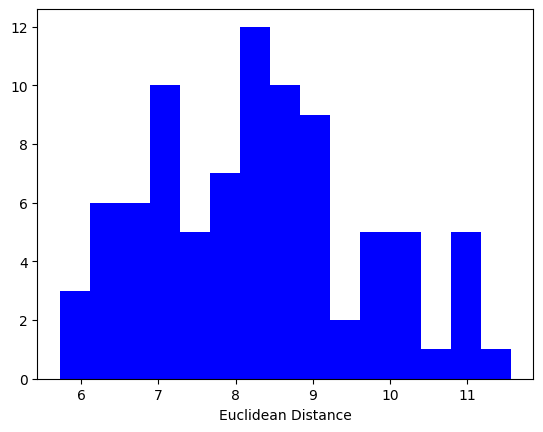

In [83]:
cw_ = []
for b in range(len(final_results)):
  cw_.append(euclidean_distance(final_results [b][0], final_results [b][1]))

plt.figure()
plt.hist(cw_, color='blue', bins=15)
plt.xlabel("Euclidean Distance")
plt.show()

In [99]:
def plot_cw_attacks(image_number):
  fig = plt.figure(figsize=(10, 10))

  rows = 1
  columns = 2

  fig.add_subplot(rows, columns, 1)
  plt.imshow(final_results[image_number][0], cmap='gray')
  plt.axis('off')
  plt.title(f'Original Image \n prediction: {final_results[image_number][2]}')

  fig.add_subplot(rows, columns, 2)
  plt.imshow(final_results[image_number][1], cmap='gray')
  plt.axis('off')
  plt.title(f'Adversarial Image \n Prediction: {final_results[image_number][3]}')


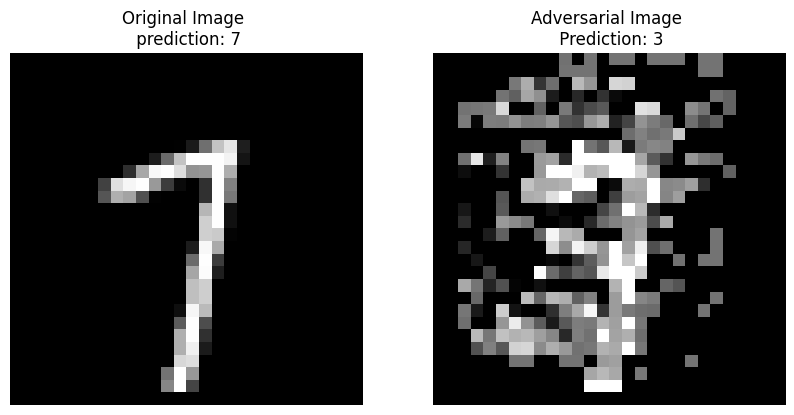

In [105]:
plot_cw_attacks(cw_.index(min(cw_)))

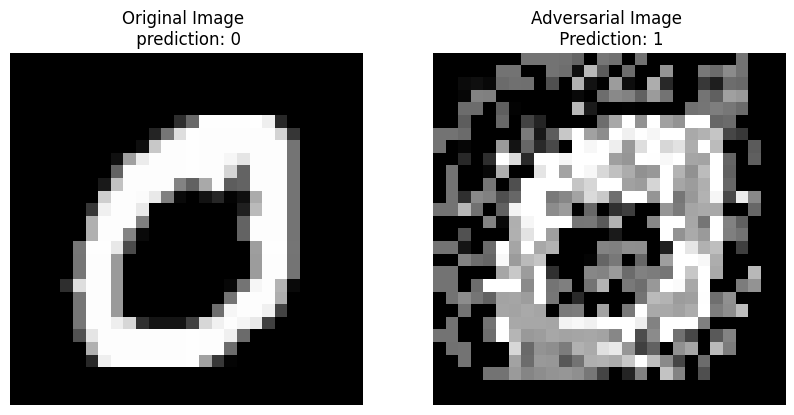

In [106]:
plot_cw_attacks(cw_.index(max(cw_)))

In [2]:
plot_cw_attacks(2)

NameError: name 'plot_cw_attacks' is not defined